# 17. Random Forest and Gradient Boosted Trees Classifier

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rhennig/EMA6938/blob/main/Notebooks/17.RandomForest.ipynb)

Previously, we used a Decision Tree Classifier to learn the fcc, bcc, and hcp crystal structure of 47 elements with Scikit-learn. Now, we will train a random forest and a gradient boosted trees model.

Let's first load the required libraries.

In [1]:
# Install the mendeleev and poymatgen packages using pip in the current Jupyter kernel
# To use them, you may need to restart the kernel
import sys
!{sys.executable} -m pip install mendeleev
!{sys.executable} -m pip install pymatgen

import pymatgen as pymat
from pymatgen.core.periodic_table import Element
import mendeleev as mendel
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt

### Getting the dataset

We select 47 elements that occur in the fcc, hcp, and bcc structure. The elements listed were chosen because querying them for these properties yields a dataset with no unknown values, and because they represent the three most common crystallographic structures.

We then query both Pymatgen and Mendeleev to get a complete set of properties per element. We will use this data to create the features from which the model will train and test. 

In [2]:
fcc_elements = ["Ag", "Al", "Au", "Cu", "Ir", "Ni", "Pb", "Pd", "Pt", "Rh", "Th", "Yb"]
bcc_elements = ["Ba", "Ca", "Cr", "Cs", "Eu", "Fe", "Li", "Mn", "Mo", "Na", "Nb", "Rb", "Ta", "V", "W" ]
hcp_elements = ["Be", "Cd", "Co", "Dy", "Er", "Gd", "Hf", "Ho", "Lu", "Mg", "Re", 
                "Ru", "Sc", "Tb", "Ti", "Tl", "Tm", "Y", "Zn", "Zr"]

elements = fcc_elements + bcc_elements + hcp_elements

random.Random(1).shuffle(elements)

querable_mendeleev = ["atomic_number", "atomic_volume", "boiling_point", "en_ghosh",  "evaporation_heat", "heat_of_formation",
                      "melting_point", "specific_heat"]
querable_pymatgen = ["atomic_mass", "atomic_radius", "electrical_resistivity","molar_volume", "bulk_modulus", "youngs_modulus",
                     "average_ionic_radius", "density_of_solid", "coefficient_of_linear_thermal_expansion"]
querable_values = querable_mendeleev + querable_pymatgen

We will use the database queries to populate a pandas dataframe.

In [3]:
all_values = [] # Values for Attributes
all_labels = [] # Crystal structure labels (0 = fcc, 1 = bcc, 2 = hcp)

for item in elements:
    element_values = []
    
    # This section queries Mendeleev
    element_object = mendel.element(item)
    for i in querable_mendeleev:    
        element_values.append(getattr(element_object,i))

    # This section queries Pymatgen
    element_object = Element(item)    
    for i in querable_pymatgen:
        element_values.append(getattr(element_object,i))
        
    all_values.append(element_values) # All lists are appended to another list, creating a List of Lists
    
    if (item in fcc_elements):
        all_labels.append(0) # The crystal structure labels are assigned here
    elif (item in bcc_elements):
        all_labels.append(1) # The crystal structure labels are assigned here
    elif (item in hcp_elements):
        all_labels.append(2) # The crystal structure labels are assigned here

# Pandas Dataframe
df = pd.DataFrame(all_values, columns=querable_values)

# We will patch some of the values that are not available in the datasets.

# Value for the CTE of Cesium
index_Cs = df.index[df['atomic_number'] == 55]
df.iloc[index_Cs, df.columns.get_loc("coefficient_of_linear_thermal_expansion")] = 0.000097 
# Value from: David R. Lide (ed), CRC Handbook of Chemistry and Physics, 84th Edition. CRC Press. Boca Raton, Florida, 2003

# Value for the CTE of Rubidium
index_Rb = df.index[df['atomic_number'] == 37]
df.iloc[index_Rb, df.columns.get_loc("coefficient_of_linear_thermal_expansion")] = 0.000090 
# Value from: https://www.azom.com/article.aspx?ArticleID=1834

# Value for the Evaporation Heat of Ruthenium
index_Ru = df.index[df['atomic_number'] == 44]
df.iloc[index_Ru, df.columns.get_loc("evaporation_heat")] = 595 # kJ/mol 
# Value from: https://www.webelements.com/ruthenium/thermochemistry.html

# Value for the Bulk Modulus of Zirconium
index_Zr = df.index[df['atomic_number'] == 40]
df.iloc[index_Zr, df.columns.get_loc("bulk_modulus")] = 94 # GPa 
# Value from: https://materialsproject.org/materials/mp-131/

df.head(n=10)

,atomic_number,atomic_volume,boiling_point,en_ghosh,evaporation_heat,heat_of_formation,melting_point,specific_heat,atomic_mass,atomic_radius,electrical_resistivity,molar_volume,bulk_modulus,youngs_modulus,average_ionic_radius,density_of_solid,coefficient_of_linear_thermal_expansion
0,27,6.70,3143.0,0.143236,389.1,426.7,1768.00,0.456,58.933195,1.35,6.000000e-08,6.67,180.0,209.0,0.768333,8900.0,0.000013
1,69,18.10,2220.0,0.216724,232.0,232.2,1818.00,0.160,168.934210,1.75,6.760000e-07,19.10,45.0,74.0,1.095000,9321.0,0.000013
2,39,19.80,3611.0,0.121699,367.0,424.7,1795.00,0.284,88.905850,1.80,6.000000e-07,19.88,41.0,64.0,1.040000,4472.0,0.000011
3,75,8.85,5900.0,0.243516,704.0,774.0,3453.00,0.138,186.207000,1.35,1.800000e-07,8.86,370.0,463.0,0.712500,21020.0,0.000006
4,28,6.60,3005.0,0.147207,378.6,430.1,1726.00,0.443,58.693400,1.35,7.200000e-08,6.59,180.0,200.0,0.740000,8908.0,0.000013
5,67,18.70,2968.0,0.207795,301.0,300.6,1747.00,0.164,164.930320,1.75,8.140000e-07,18.74,40.0,65.0,1.041000,8795.0,0.000011
6,79,10.20,3080.0,0.261370,340.0,368.2,1337.58,0.129,196.966569,1.35,2.200000e-08,10.21,220.0,78.0,1.070000,19300.0,0.000014
7,21,15.00,3104.0,0.119383,332.7,377.8,1814.00,0.556,44.955912,1.60,5.500000e-07,15.00,57.0,74.0,0.885000,2985.0,0.000010
8,45,8.30,4000.0,0.140838,494.0,556.0,2239.00,0.244,102.905500,1.35,4.300000e-08,8.28,380.0,275.0,0.745000,12450.0,0.000008
9,74,9.53,5930.0,0.239050,824.0,851.0,3680.00,0.133,183.840000,1.35,5.400000e-08,9.47,310.0,411.0,0.766667,19250.0,0.000005


### Processing and Organizing Data

We normalize the data and randomly split it into training and testing sets.

##### SETS

We have 47 elements for which the crystal structure is known and we will use 40 of these as a training set and the remaining 7 as testing set.

##### NORMALIZATION

We will again use the Standard Score Normalization, which subtracts the mean of the feature and divide by its standard deviation.
$$
\frac{X - µ}{σ}
$$
While our model might converge without feature normalization, the resultant model would be difficult to train and would be dependent on the choice of units used in the input.

In [4]:
# SETS
all_values = [list(df.iloc[x]) for x in range(len(all_values))]

# List of lists are turned into Numpy arrays to facilitate calculations in steps to follow
# (Normalization).
all_values = np.array(all_values, dtype = float)
print("Shape of Values:", all_values.shape)
all_labels = np.array(all_labels, dtype = int)
print("Shape of Labels:", all_labels.shape)

# Training Set
train_values = all_values[:40, :]
train_labels = all_labels[:40]

# Testing Set
test_values = all_values[-7:, :]
test_labels = all_labels[-7:]

# NORMALIZATION

mean = np.nanmean(train_values, axis = 0) # mean
std = np.nanstd(train_values, axis = 0) # standard deviation

train_values = (train_values - mean) / std # input scaling
test_values = (test_values - mean) / std # input scaling

print(train_values[0]) # print a sample entry from the training set
print(train_labels[0])

Shape of Values: (47, 17)
Shape of Labels: (47,)
[-0.80084167 -0.75983551 -0.00894162 -0.40732945  0.15599373  0.16654528
  0.09455406  0.02631292 -0.82400017 -0.80570946 -0.67799461 -0.75661221
  0.70972845  0.6516648  -0.77257498  0.11409173 -0.3075323 ]
2


### Creating the Random Forest Model

For this classification, we will use a random forest.

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

# Create Decision Tree classifer object
model = RandomForestClassifier()

# Train Decision Tree Classifer
model.fit(train_values, train_labels)

RandomForestClassifier()

### Validation

We calculate the accuracy score on the training and the testing sets.

In [6]:
#Predict the response for training and testing dataset
train_pred = model.predict(train_values)
test_pred = model.predict(test_values)

# Model Accuracy for training and testing set, how often is the classifier correct?

print('Training accuracy = %.3f ' % accuracy_score(train_labels, train_pred))
print('Testing accuracy  = %.3f ' % accuracy_score(test_labels, test_pred))

Training accuracy = 1.000 
Testing accuracy  = 0.429 


### Visualize the random forest model

Since the random forest consists of many decision trees, we can visualize the individual decision trees.

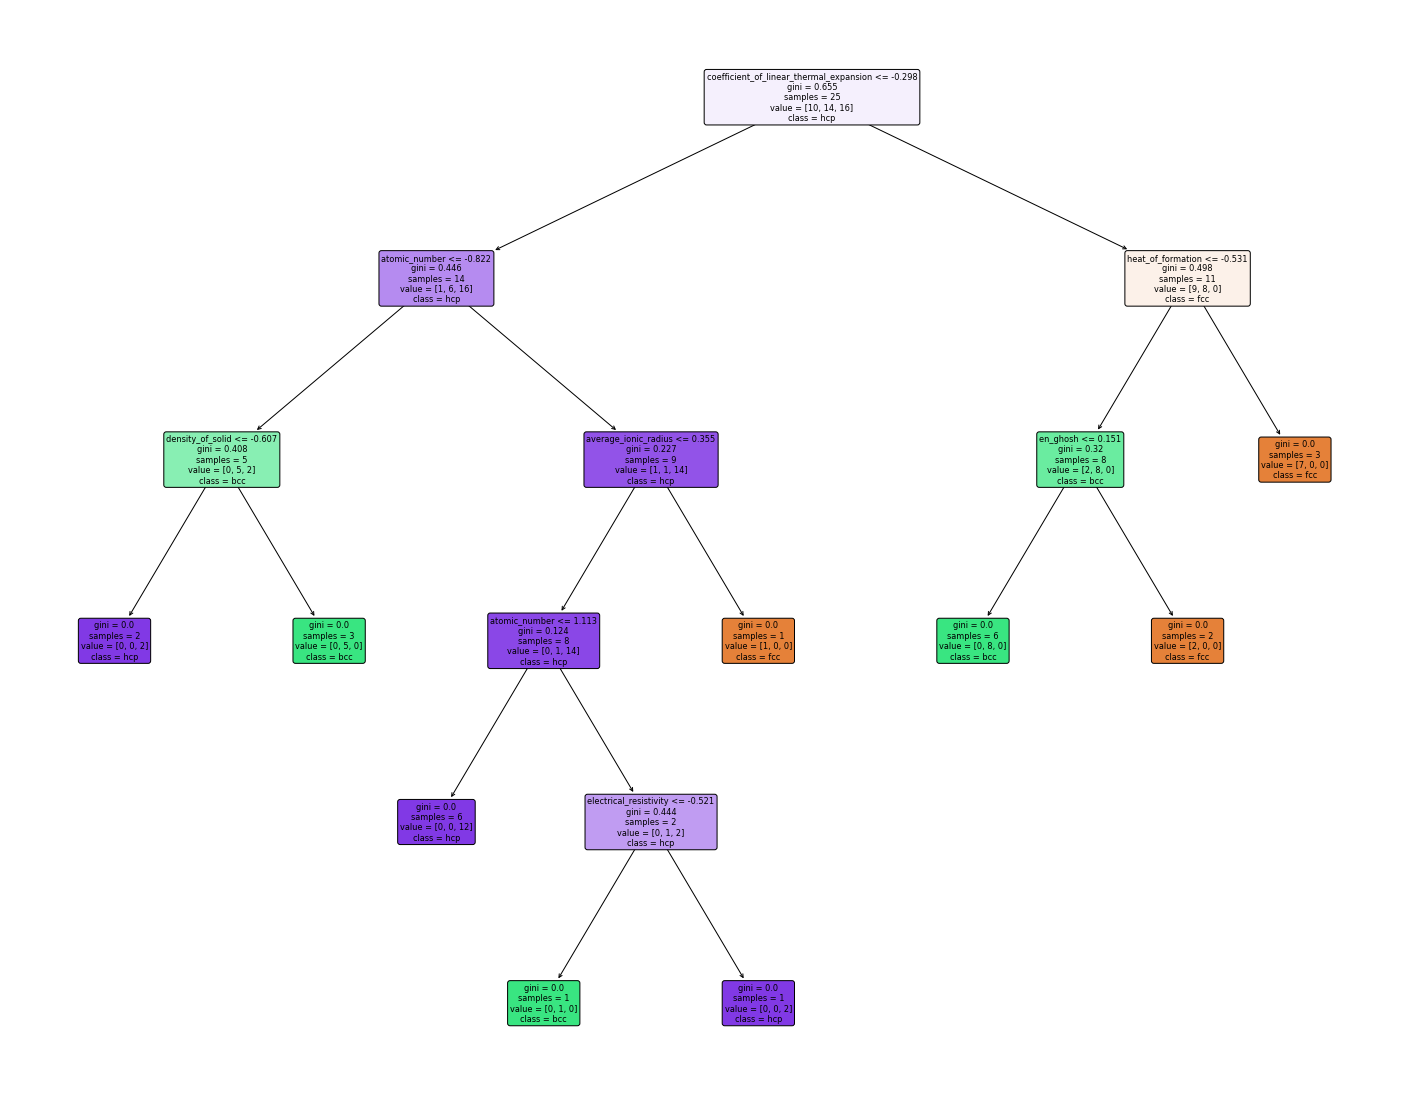

In [7]:
label_names = ('fcc', 'bcc', 'hcp')
fig = plt.figure(figsize=(25,20))

# Select an individual decision tree, here 0.
_ = tree.plot_tree(model.estimators_[0], feature_names=querable_values,
                   class_names = label_names, filled=True, impurity=True, rounded=True)

In [8]:
train_predictions = model.predict(train_values)
test_predictions = model.predict(test_values)

print("train_labels = ", train_labels)
print("test_labels = ", test_labels)

all_labels = np.hstack((train_labels, test_labels))
all_predictions = np.hstack((train_predictions, test_predictions))

predicted_labels = []
true_labels = []

for i in range(all_predictions.shape[0]):
    if (all_predictions[i] == 0):
        predicted_labels.append("FCC")
    if (all_labels[i] == 0):
        true_labels.append("FCC")
    if (all_predictions[i] == 1):
        predicted_labels.append("BCC")
    if (all_labels[i] == 1):
        true_labels.append("BCC")
    if (all_predictions[i] == 2):
        predicted_labels.append("HCP")
    if (all_labels[i] == 2):
        true_labels.append("HCP")

predicted_labels = np.array(predicted_labels).reshape((-1, 1))
true_labels = np.array(true_labels).reshape((-1, 1))
headings = ["Atomic number", "True crystal structure", "Predicted crystal structure"]

atomic_number_array = np.array(df.iloc[:, 0]).reshape((-1, 1))
plot_table = np.concatenate((atomic_number_array, true_labels, predicted_labels), axis=1)

plot_df = pd.DataFrame(plot_table, columns=headings)

train_labels =  [2 2 2 2 0 2 0 2 0 1 2 2 2 0 1 2 1 1 1 1 1 2 0 0 1 2 1 1 2 1 1 0 2 2 0 2 0
 1 1 2]
test_labels =  [2 2 0 1 0 2 0]


In [9]:
plot_df

,Atomic number,True crystal structure,Predicted crystal structure
0,27,HCP,HCP
1,69,HCP,HCP
2,39,HCP,HCP
3,75,HCP,HCP
4,28,FCC,FCC
5,67,HCP,HCP
6,79,FCC,FCC
7,21,HCP,HCP
8,45,FCC,FCC
9,74,BCC,BCC


### Questions:

#### Hyperparameter optimization

1. We can select the `criterion` parameter to measure the quality of a split. The default value is `'squared_error'`.

2. When the algorithm performs a split, the main goal is to decrease impurity as much as possible. The more the impurity decreases, the more informative power that split gains. As the tree gets deeper, the amount of impurity decrease becomes lower. We can use this to prevent the tree from doing further splits. The hyperparameter for this task is `min_impurity_decrease`. Its default is zero. Try changing it to see the difference.

3. If the algorithm keeps splitting nodes, the model will probably be overfit. The `min_samples_split` parameter can be used to control the tree based on impurity values. It sets a threshold on gini. Try setting it to 0.3, so a node needs to have a gini value that is more then 0.3 to be further split.

4. Another hyperparameter to control the depth of a tree is `max_depth`. It does not make any calculations regarding impurity or sample ratio. The model stops splitting when max_depth is reached. Note that `max_depth` is less flexible compared to min_impurity_decrease.

5. Another hyperparameter is `min_samples_leaf`. It indicates the minimum number of samples required to be at a leaf node.

6. We can also limit the number of leaf nodes using `max_leaf_nodes` parameter which grows the tree in best-first fashion until max_leaf_nodes reached. The best split is decided based on impurity decrease.

7. Another important hyperparameter of decision trees is `max_features` which is the number of features to consider when looking for the best split. If not specified, the model considers all of the features. There is only 1 feature in our dataset.

To change the hyperparameters:

`regressor = RandomForestRegressor(hyperparameter = value)`

Change the `max_depth` and `min_samples_split` to see how this affects the training and prediction error.

Training accuracy = 0.775 
Testing accuracy  = 0.286 


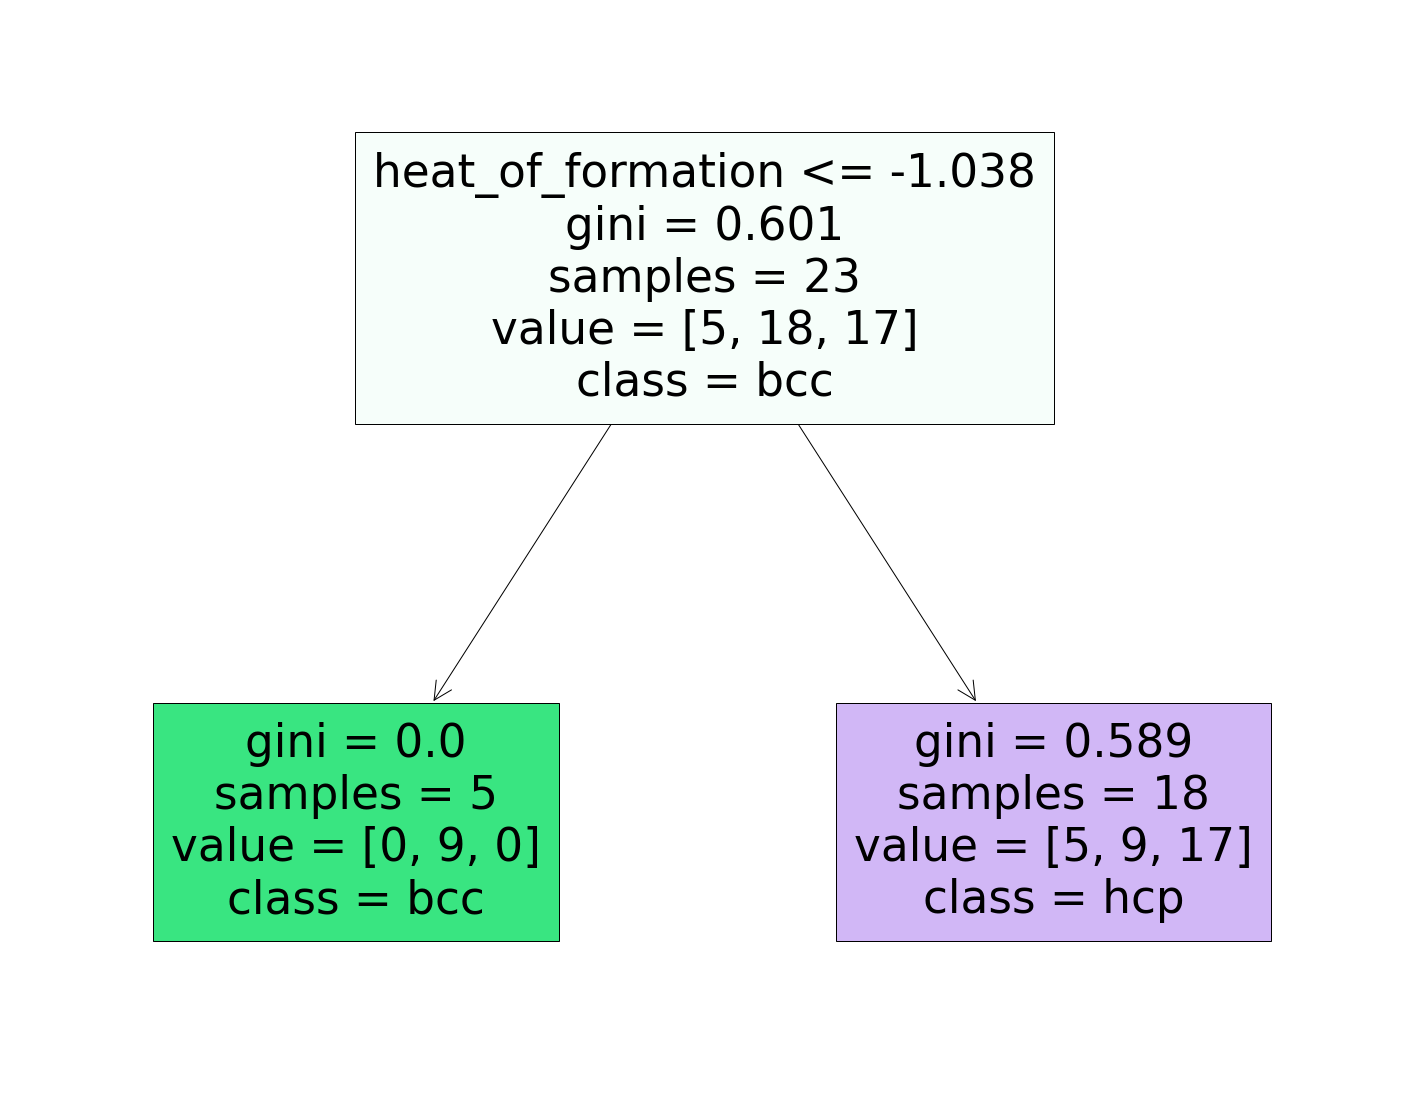

In [10]:
# Create Decision Tree classifer object
model = RandomForestClassifier(max_depth=3, min_samples_split=0.5)

# Train Decision Tree Classifer
model.fit(train_values, train_labels)

#Predict the response for training and testing dataset
train_pred = model.predict(train_values)
test_pred = model.predict(test_values)

# Model Accuracy for training and testing set, how often is the classifier correct?

print('Training accuracy = %.3f ' % accuracy_score(train_labels, train_pred))
print('Testing accuracy  = %.3f ' % accuracy_score(test_labels, test_pred))

label_names = ('fcc', 'bcc', 'hcp')
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model.estimators_[0], feature_names=querable_values, class_names = label_names, filled=True)

### Creating the Gradient Boosted Trees Model

Next, we will test gradient boosted trees for this classification.

In [11]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

# Create Decision Tree classifer object
model = GradientBoostingClassifier()

# Train Decision Tree Classifer
model.fit(train_values, train_labels)

GradientBoostingClassifier()

### Validation

We calculate the accuracy score on the training and the testing sets.

In [12]:
#Predict the response for training and testing dataset
train_pred = model.predict(train_values)
test_pred = model.predict(test_values)

# Model Accuracy for training and testing set, how often is the classifier correct?

print('Training accuracy = %.3f ' % accuracy_score(train_labels, train_pred))
print('Testing accuracy  = %.3f ' % accuracy_score(test_labels, test_pred))

Training accuracy = 1.000 
Testing accuracy  = 0.571 


As we can see, for this dataset all the tree-based models do comparably well.